In [1]:
%load_ext autoreload
%autoreload 2
from exojax.spec import make_numatrix,voigt,lorentz
from exojax.spec import rtransfer as rt
from exojax.spec import planck
import numpy as np
import jax.numpy as jnp
from jax import random
from jax.lax import map, scan
from jax import vmap, jit
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import hapi
hapi.db_begin('/home/kawahara/hapi/data/CO')

HAPI version: 1.1.2.0
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2017 are now available in HAPI code

           It is free to use HAPI. If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005
Using /home/kawahara/hapi/data/CO

05_HITEMP2019
                     Lines parsed: 752976


In [3]:
#hapi.describeTable('05_HITEMP2019')

In [5]:
import numpy as np
import astropy.units as u
#nm
llow=2290.0
lhigh=2450.0
#cm-1
wlow=1.e7/lhigh
whigh=1.e7/llow

wls = (np.arange(22900, 24500, 1.0) * u.Angstrom)[::-1]
nus = wls.to(1/u.cm, equivalencies=u.spectral()).value
wls = wls.value
nu_lo, nu_hi = nus.min().astype(np.int), nus.max().astype(np.int)

In [151]:
wlow,whigh


(4081.6326530612246, 4366.812227074236)

In [10]:
nus, wls = jnp.array(nus), jnp.array(wls)

In [12]:
molec='05_HITEMP2019'
n_air_all = hapi.getColumn(molec, 'n_air')
gamma_air_all = hapi.getColumn(molec, 'gamma_air')
gamma_self_all = hapi.getColumn(molec, 'gamma_self')
nu_lines_all = hapi.getColumn(molec, 'nu')
delta_air_all = hapi.getColumn(molec, 'delta_air')
S_ij_all = hapi.getColumn(molec, 'sw')
elower_all = hapi.getColumn(molec, 'elower')
gpp_all = hapi.getColumn(molec, 'gpp')

In [108]:
S_ij_all

array([2.700e-164, 6.503e-162, 3.667e-166, ..., 1.933e-031, 2.038e-031,
       2.011e-031])

In [149]:
margin=100
crit=1.e-98
#crit=1.e-300
#mask=(S_ij_all>crit)
mask=(nu_lines_all>nus[0]-margin)*(nu_lines_all<nus[-1]+margin)*(S_ij_all>crit)
#mask=(nu_lines_all>nus[0]-margin)*(nu_lines_all<nus[-1]+margin)#*(S_ij_all>crit)

n_air=n_air_all[mask]
gamma_air=gamma_air_all[mask]
gamma_self=gamma_self_all[mask] 
nu_lines=nu_lines_all[mask] 
delta_air=delta_air_all[mask]
S_ij0=S_ij_all[mask]
elower=elower_all[mask]
gpp=gpp_all[mask]

sij0=np.log(S_ij0) #use numpy not jnp

In [142]:
Tfix=300.0

In [143]:
@jit
def QT(T, g_k, E_k):
    '''Total Internal Partition Sum'''
    c_2 = 1.4387770 #cm K
    return jnp.sum( g_k * jnp.exp(- c_2 * E_k / T) )

In [144]:


@jit
def SijT(T,sij0,nu_ij,glower,elower,qT):
    """
    qT=Q(Tref)/Q(T)
    """
    c_2 = 1.4387770 
    expow=sij0-c_2*(elower/T-elower/Tref)
    fac=(1.0-jnp.exp(-c_2*nu_ij/T) )/(1.0-jnp.exp(-c_2*nu_ij/Tref))
    return jnp.exp(expow)*qT*fac

In [145]:
Qr=hapi.partitionSum(5,6, [296,2000.0])
print(Qr[1]/Qr[0])
print(QT(2000.0, gpp_all, elower_all)/QT(Tref, gpp_all, elower_all))

8.777110568900262
8.780128


In [75]:
@jit
def gamma_hitran(P, T, Pself, n_air, gamma_air_ref, gamma_self_ref):
    return (Tref/T)**n_air *(gamma_air_ref*(P-Pself) + gamma_self_ref*(Pself))


In [125]:
from scipy.constants import Boltzmann, proton_mass, speed_of_light

In [119]:
np.sqrt(Boltzmann/proton_mass)/speed_of_light # if T is given

3.030553629297519e-07

In [146]:
def Doppler_sigma(nu,T,M):
    c3=3.030553629297519e-07
    return c3*jnp.sqrt(T/M)*nu

In [147]:
Mmol=2.0
sigmaD=1.0
Tref=296.0
Tfix=2000.0
Pfix=1.0#atm

nu0fix = 0.0
numatrix=make_numatrix(nus,nu_lines,nu0fix)

Q0=QT(Tref, gpp_all, elower_all)
QTc=QT(Tfix, gpp_all, elower_all)
Sij=SijT(Tfix,sij0,nu_lines,gpp,elower,Q0/QTc)

gammas = vmap(gamma_hitran, in_axes=(None, None, None, 0, 0, 0)) \
(Pfix,Tfix,0.001, n_air, gamma_air, gamma_self)

vvoigt=jit(vmap(voigt,(0,0,0),0)) #we assume all of the input is vmaped.
#vlorentz=jit(vmap(lorentz,(0,0),0))
sigmaD=Doppler_sigma(nu_lines,Tfix,Mmol)
xsv = jnp.dot((vvoigt(numatrix,sigmaD,gammas)).T,Sij)
#xsv_l = jnp.dot((vlorentz(numatrix,gammas)).T,Sij)

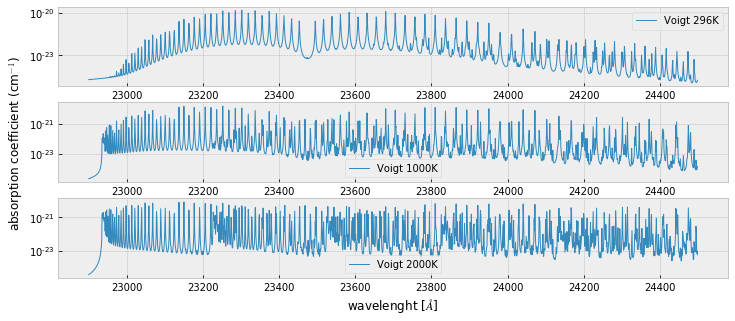

In [150]:
import matplotlib.pyplot as plt
#plt.plot(wls,xsv_l,lw=0.5,label="Lorentz")
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(311)
plt.plot(wls,xsv296,lw=1.0,label="Voigt 296K")
plt.legend()
plt.yscale("log")
ax=fig.add_subplot(312)
plt.plot(wls,xsv1000,lw=1.0,label="Voigt 1000K")
plt.yscale("log")
plt.ylabel('absorption coefficient (cm$^{-1}$)')
plt.legend()
ax=fig.add_subplot(313)
plt.plot(wls,xsv2000,lw=1.0,label="Voigt 2000K")
plt.yscale("log")
plt.xlabel('wavelenght [$\AA$]')
plt.legend()
#plt.xlim(23200.,23230.)
plt.savefig("co_hitemp.png")
plt.show()